In [1]:
import numpy as np
import pandas as pd
import os

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from scipy.special import rel_entr
from scipy.stats import entropy
import scipy.stats
import math
import warnings 
warnings.filterwarnings("ignore") 

In [2]:
# 使用GPU
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
! nvidia-smi

Sun May 15 16:16:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 34%   43C    P8    39W / 260W |     22MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 29%   

# Company數量

In [4]:
from pymongo import MongoClient
import pymongo

In [5]:
mongoURI = "mongodb://%s:%s@%s/%s?authMechanism=SCRAM-SHA-1" % ("eva", "eva_30241", "140.117.69.70:30241", "eva")

try:
    conn = pymongo.MongoClient(mongoURI)
    db = conn.eva
    db_de = db.patent_de
    db_us = db.patent_us
    db_cn = db.patent_cn
    db_cn_5 = db.w_patent_cn_5
    db_cn_10 = db.w_patent_cn_10
    db_us_5 = db.w_patent_us_5
    db_us_10 = db.w_patent_us_10
    db_de_5 = db.w_patent_de_5
    db_de_10 = db.w_patent_de_10
except errors.ConnectionFailure as err:
    print(err)

In [6]:
# data_assignee = db_de.aggregate([
#     {"$unwind" : "$current_assignee"},
#     {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
#     {"$sort": {"count":-1}},
#     {"$limit":30}
# ])

# ls_company = []
# ls_count = []
# for data in data_assignee:
#     # print(data["_id"],data["count"])
#     ls_company.append(data["_id"])
#     ls_count.append(data["count"])

In [7]:
# df_family_de = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [8]:
# data_assignee = db_cn.aggregate([
#     {"$unwind" : "$current_assignee"},
#     {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
#     {"$sort": {"count":-1}},
#     {"$limit":30}
# ])

# ls_company = []
# ls_count = []
# for data in data_assignee:
#     # print(data["_id"],data["count"])
#     ls_company.append(data["_id"])
#     ls_count.append(data["count"])
    
# df_family_cn = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [9]:
data_assignee = db_us_5.aggregate([
    {"$unwind" : "$current_assignee"},
    {"$group" : {"_id" : "$current_assignee", "count":{"$sum":1}}},
    {"$sort": {"count":-1}},
    {"$limit":30}
])

ls_company = []
ls_count = []
for data in data_assignee:
    # print(data["_id"],data["count"])
    ls_company.append(data["_id"])
    ls_count.append(data["count"])
    
df_family_us = pd.DataFrame((zip(ls_company, ls_count)), columns = ['company', 'count'])

In [10]:
# final_df = pd.concat([df_family_de,df_family_cn,df_family_us],axis=0)

In [11]:
final_df = df_family_us.copy()

In [12]:
# 取總數前15家公司
final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)

,company,count
24,Samsung Electronics Co Ltd,369
11,Intel Corp,349
6,Cisco Technology Inc,224
22,Qualcomm Inc,179
26,Telefonaktiebolaget LM Ericsson AB,146
16,LG Electronics Inc,71
13,International Business Machines Corp,57
18,Microsoft Technology Licensing LLC,57
7,Convida Wireless LLC,55
1,Afero Inc,52


In [13]:
com_df = final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)

In [14]:
com_df.reset_index(drop=True, inplace=True)

In [15]:
# com_ls = list(final_df.groupby("company").sum().reset_index().sort_values("count",ascending=False).head(15)["company"])
# com_ls

['Qualcomm Inc',
 'Samsung Electronics Co Ltd',
 'Intel Corp',
 'Telefonaktiebolaget LM Ericsson AB',
 'Huawei Technologies Co Ltd',
 'LG Electronics Inc',
 'International Business Machines Corp',
 'Apple Inc',
 'Cisco Technology Inc',
 'Microsoft Technology Licensing LLC',
 'Micron Technology Inc',
 'Sony Corp',
 'Nokia Technologies Oy',
 'Shenzhen Shenglu IoT Communication Technology Co Ltd',
 'NTT Docomo Inc']

In [16]:
# com_ls=['Qualcomm Inc', 'Samsung Electronics Co Ltd', 'Intel Corp', 'Telefonaktiebolaget LM Ericsson AB', 'Huawei Technologies Co Ltd', 'LG Electronics Inc', 'International Business Machines Corp', 'Apple Inc', 'Cisco Technology Inc', 'Microsoft Technology Licensing LLC', 'Micron Technology Inc', 'Sony Corp', 'Nokia Technologies Oy', 'Shenzhen Shenglu IoT Communication Technology Co Ltd', 'NTT Docomo Inc']

In [17]:
# com_count = [8491,6337,3236,2488,2461,1931,1591,1104,1092,963,731,711,668,656,612]

In [18]:
# com_df = pd.DataFrame((zip(com_ls, com_count)), columns = ['company', 'count'])

In [19]:
com_df["count_log"] = com_df["count"].apply(lambda x: np.log(x))

In [20]:
com_df

,company,count,count_log
0,Samsung Electronics Co Ltd,369,5.910797
1,Intel Corp,349,5.855072
2,Cisco Technology Inc,224,5.411646
3,Qualcomm Inc,179,5.187386
4,Telefonaktiebolaget LM Ericsson AB,146,4.983607
5,LG Electronics Inc,71,4.262680
6,International Business Machines Corp,57,4.043051
7,Microsoft Technology Licensing LLC,57,4.043051
8,Convida Wireless LLC,55,4.007333
9,Afero Inc,52,3.951244


In [21]:
com_ls = list(com_df.company)

In [22]:
# com_df.to_csv("com_df_us.csv",index=0)

In [23]:
# com_df = pd.read_csv("./com_df_us.csv")

In [24]:
# com_ls = list(com_df.company)

# Data

In [25]:
ccontry = pd.read_csv("./final_data/w_company_country_us_5.csv")

In [26]:
ccpc = pd.read_csv("./final_data/w_company_cpc_us_5.csv")

In [27]:
ccontry[ccontry.company.isin(com_ls)].head()

,company,AR,AU,BR,CA,CN,DE,DK,EA,EC,...,RS,RU,SA,SE,SG,TW,UA,US,WO,ZA
26,Afero Inc,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62.0,10.0,0.0
46,Apple Inc,0.0,2.0,12.0,2.0,53.0,8.0,0.0,0.0,0.0,...,0.0,3.0,0.0,1.0,0.0,18.0,0.0,69.0,57.0,0.0
121,Cisco Technology Inc,0.0,1.0,0.0,13.0,20.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,226.0,84.0,0.0
132,Convida Wireless LLC,0.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0,55.0,0.0
178,Electronics and Telecommunications Research In...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,47.0,0.0,0.0


# Similarity計算

## Country

- 換成機率  
- 比例vs機率(?)  

[KL](https://datascience.stackexchange.com/questions/9262/calculating-kl-divergence-in-python)  
[KL neg](https://stats.stackexchange.com/questions/41297/kullback-leibler-divergence-negative-values)

In [28]:
ccontry.set_index("company", inplace=True)
ccontry2 = ccontry.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

In [29]:
P = ccontry2[ccontry2.index==com_ls[0]].values.tolist()[0][1:]
Q = ccontry2[ccontry2.index==com_ls[1]].values.tolist()[0][1:]

In [30]:
# print(P)
# print(Q)

### PCB
- 和Samsung Electronics Co Ltd比較

In [31]:
ccontry_pcb = ccontry2.loc[com_ls,:].copy()
ccontry_pcb

,AR,AU,BR,CA,CN,DE,DK,EA,EC,EP,...,RS,RU,SA,SE,SG,TW,UA,US,WO,ZA
company,,,,,,,,,,,,,,,,,,,,,
Samsung Electronics Co Ltd,0.000000,0.007457,0.000000,0.002486,0.120133,0.007457,0.000000,0.0,0.000000,0.116819,...,0.000000,0.000829,0.000000,0.00000,0.000000,0.014085,0.0,0.317316,0.128418,0.000000
Intel Corp,0.000000,0.000000,0.016102,0.000000,0.136441,0.020339,0.000000,0.0,0.000000,0.122881,...,0.000000,0.002542,0.000000,0.00000,0.004237,0.054237,0.0,0.320339,0.216949,0.000000
Cisco Technology Inc,0.000000,0.002299,0.000000,0.029885,0.045977,0.000000,0.000000,0.0,0.000000,0.193103,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.519540,0.193103,0.000000
Qualcomm Inc,0.000000,0.003341,0.022272,0.005568,0.142539,0.000000,0.000000,0.0,0.001114,0.138085,...,0.001114,0.000000,0.001114,0.00000,0.001114,0.037862,0.0,0.199332,0.184855,0.000000
Telefonaktiebolaget LM Ericsson AB,0.008977,0.003591,0.016158,0.007181,0.100539,0.000000,0.007181,0.0,0.000000,0.226212,...,0.000000,0.008977,0.000000,0.00000,0.001795,0.008977,0.0,0.265709,0.251346,0.008977
LG Electronics Inc,0.000000,0.008000,0.000000,0.008000,0.096000,0.000000,0.000000,0.0,0.000000,0.096000,...,0.000000,0.008000,0.000000,0.00000,0.000000,0.004000,0.0,0.288000,0.272000,0.000000
International Business Machines Corp,0.000000,0.000000,0.000000,0.000000,0.136364,0.045455,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.647727,0.022727,0.000000
Microsoft Technology Licensing LLC,0.000000,0.010417,0.010417,0.010417,0.166667,0.000000,0.000000,0.0,0.000000,0.166667,...,0.000000,0.010417,0.000000,0.00000,0.000000,0.010417,0.0,0.302083,0.250000,0.000000
Convida Wireless LLC,0.000000,0.000000,0.000000,0.000000,0.148789,0.000000,0.000000,0.0,0.000000,0.173010,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.190311,0.190311,0.000000


In [32]:
def PCB(a,b):
    return sum(a*b)

ccontry_pcb["sum"] = ccontry_pcb.apply(lambda x: PCB(ccontry_pcb.loc["Samsung Electronics Co Ltd",:],x), axis=1)

###### n

In [33]:
pcb_ls=[]
n=0.05

for i in ccontry_pcb.index:
    pcb = ccontry_pcb.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
    pcb_ls.append(pcb[0])
    
ccontry_pcb["pcb"]=pcb_ls

In [34]:
# ccontry_pcb.sort_values(["pcb"],ascending=True)

## CPC

In [35]:
ccpc.set_index("company", inplace=True)
ccpc2 = ccpc.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

In [36]:
ccpc_pcb = ccpc2.loc[com_ls,:].copy()
# ccpc_pcb

In [37]:
def PCB(a,b):
    return sum(a*b)

ccpc_pcb["sum"] = ccpc_pcb.apply(lambda x: PCB(ccpc_pcb.loc["Samsung Electronics Co Ltd",:],x), axis=1)

###### n

In [38]:
pcb_ls=[]
n=0.08

for i in ccpc_pcb.index:
    pcb = ccpc_pcb.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
    pcb_ls.append(pcb[0])
    
ccpc_pcb["pcb"]=pcb_ls

In [39]:
ccpc_pcb.sort_values(["pcb"],ascending=True)

,A01,A23,A41,A42,A44,A46,A47,A61,A62,A63,...,H01,H02,H03,H04,H05,Y02,Y04,Y10,sum,pcb
company,,,,,,,,,,,,,,,,,,,,,
Samsung Electronics Co Ltd,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.019220,0.000000,0.004016,...,0.076018,0.008319,0.005450,0.522375,0.017212,0.019507,0.000574,0.001721,0.324695,0.324695
Intel Corp,0.001832,0.0,0.000611,0.0,0.0,0.000611,0.001526,0.017399,0.000000,0.023504,...,0.109890,0.013126,0.002747,0.549756,0.003053,0.024115,0.000916,0.000611,0.331209,0.331458
Cisco Technology Inc,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000734,0.000000,0.000000,0.000000,...,0.001467,0.010271,0.000734,0.815847,0.000734,0.028613,0.019076,0.000000,0.448731,0.468663
Qualcomm Inc,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.012169,0.005011,0.002147,0.809592,0.006442,0.020043,0.005727,0.000000,0.445251,0.487117
Microsoft Technology Licensing LLC,0.000000,0.0,0.004338,0.0,0.0,0.000000,0.000000,0.004338,0.000000,0.000000,...,0.045553,0.030369,0.000000,0.318872,0.008677,0.019523,0.006508,0.000000,0.254713,0.533791
International Business Machines Corp,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.007463,0.022388,0.000000,0.000000,...,0.213930,0.000000,0.000000,0.353234,0.007463,0.000000,0.002488,0.000000,0.269177,0.548255
Telefonaktiebolaget LM Ericsson AB,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.001810,0.004525,0.920362,0.000000,0.018100,0.003620,0.000000,0.489653,0.558427
Xerox Corp,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.322222,0.000000,0.000000,0.000000,0.000000,0.265347,0.612177
LG Electronics Inc,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.001678,0.000000,0.000000,0.879195,0.010067,0.020134,0.000000,0.000000,0.470281,0.687584


# Scatter Plot

In [40]:
# loop test
def scatter_plot(pcb_n,cpc_n):
    # PCB
    pcb_ls=[]
    n = pcb_n
    for i in ccontry_pcb.index:
        pcb = ccontry_pcb.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
        pcb_ls.append(pcb[0])

    ccontry_pcb["pcb"]=pcb_ls
    
    # CPC
    pcb_ls=[]
    n = cpc_n
    for i in ccpc_pcb.index:
        pcb = ccpc_pcb.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Samsung Electronics Co Ltd"].values-com_df.count_log[com_df.company==i].values)**2)
        pcb_ls.append(pcb[0])

    ccpc_pcb["pcb"]=pcb_ls
    
    c_df = pd.DataFrame((zip(list(ccpc_pcb["pcb"]), list(ccontry_pcb["pcb"]))), columns = ['cpc', 'country'])
    c_df.set_index(ccpc_pcb.index, inplace=True)

    return c_df

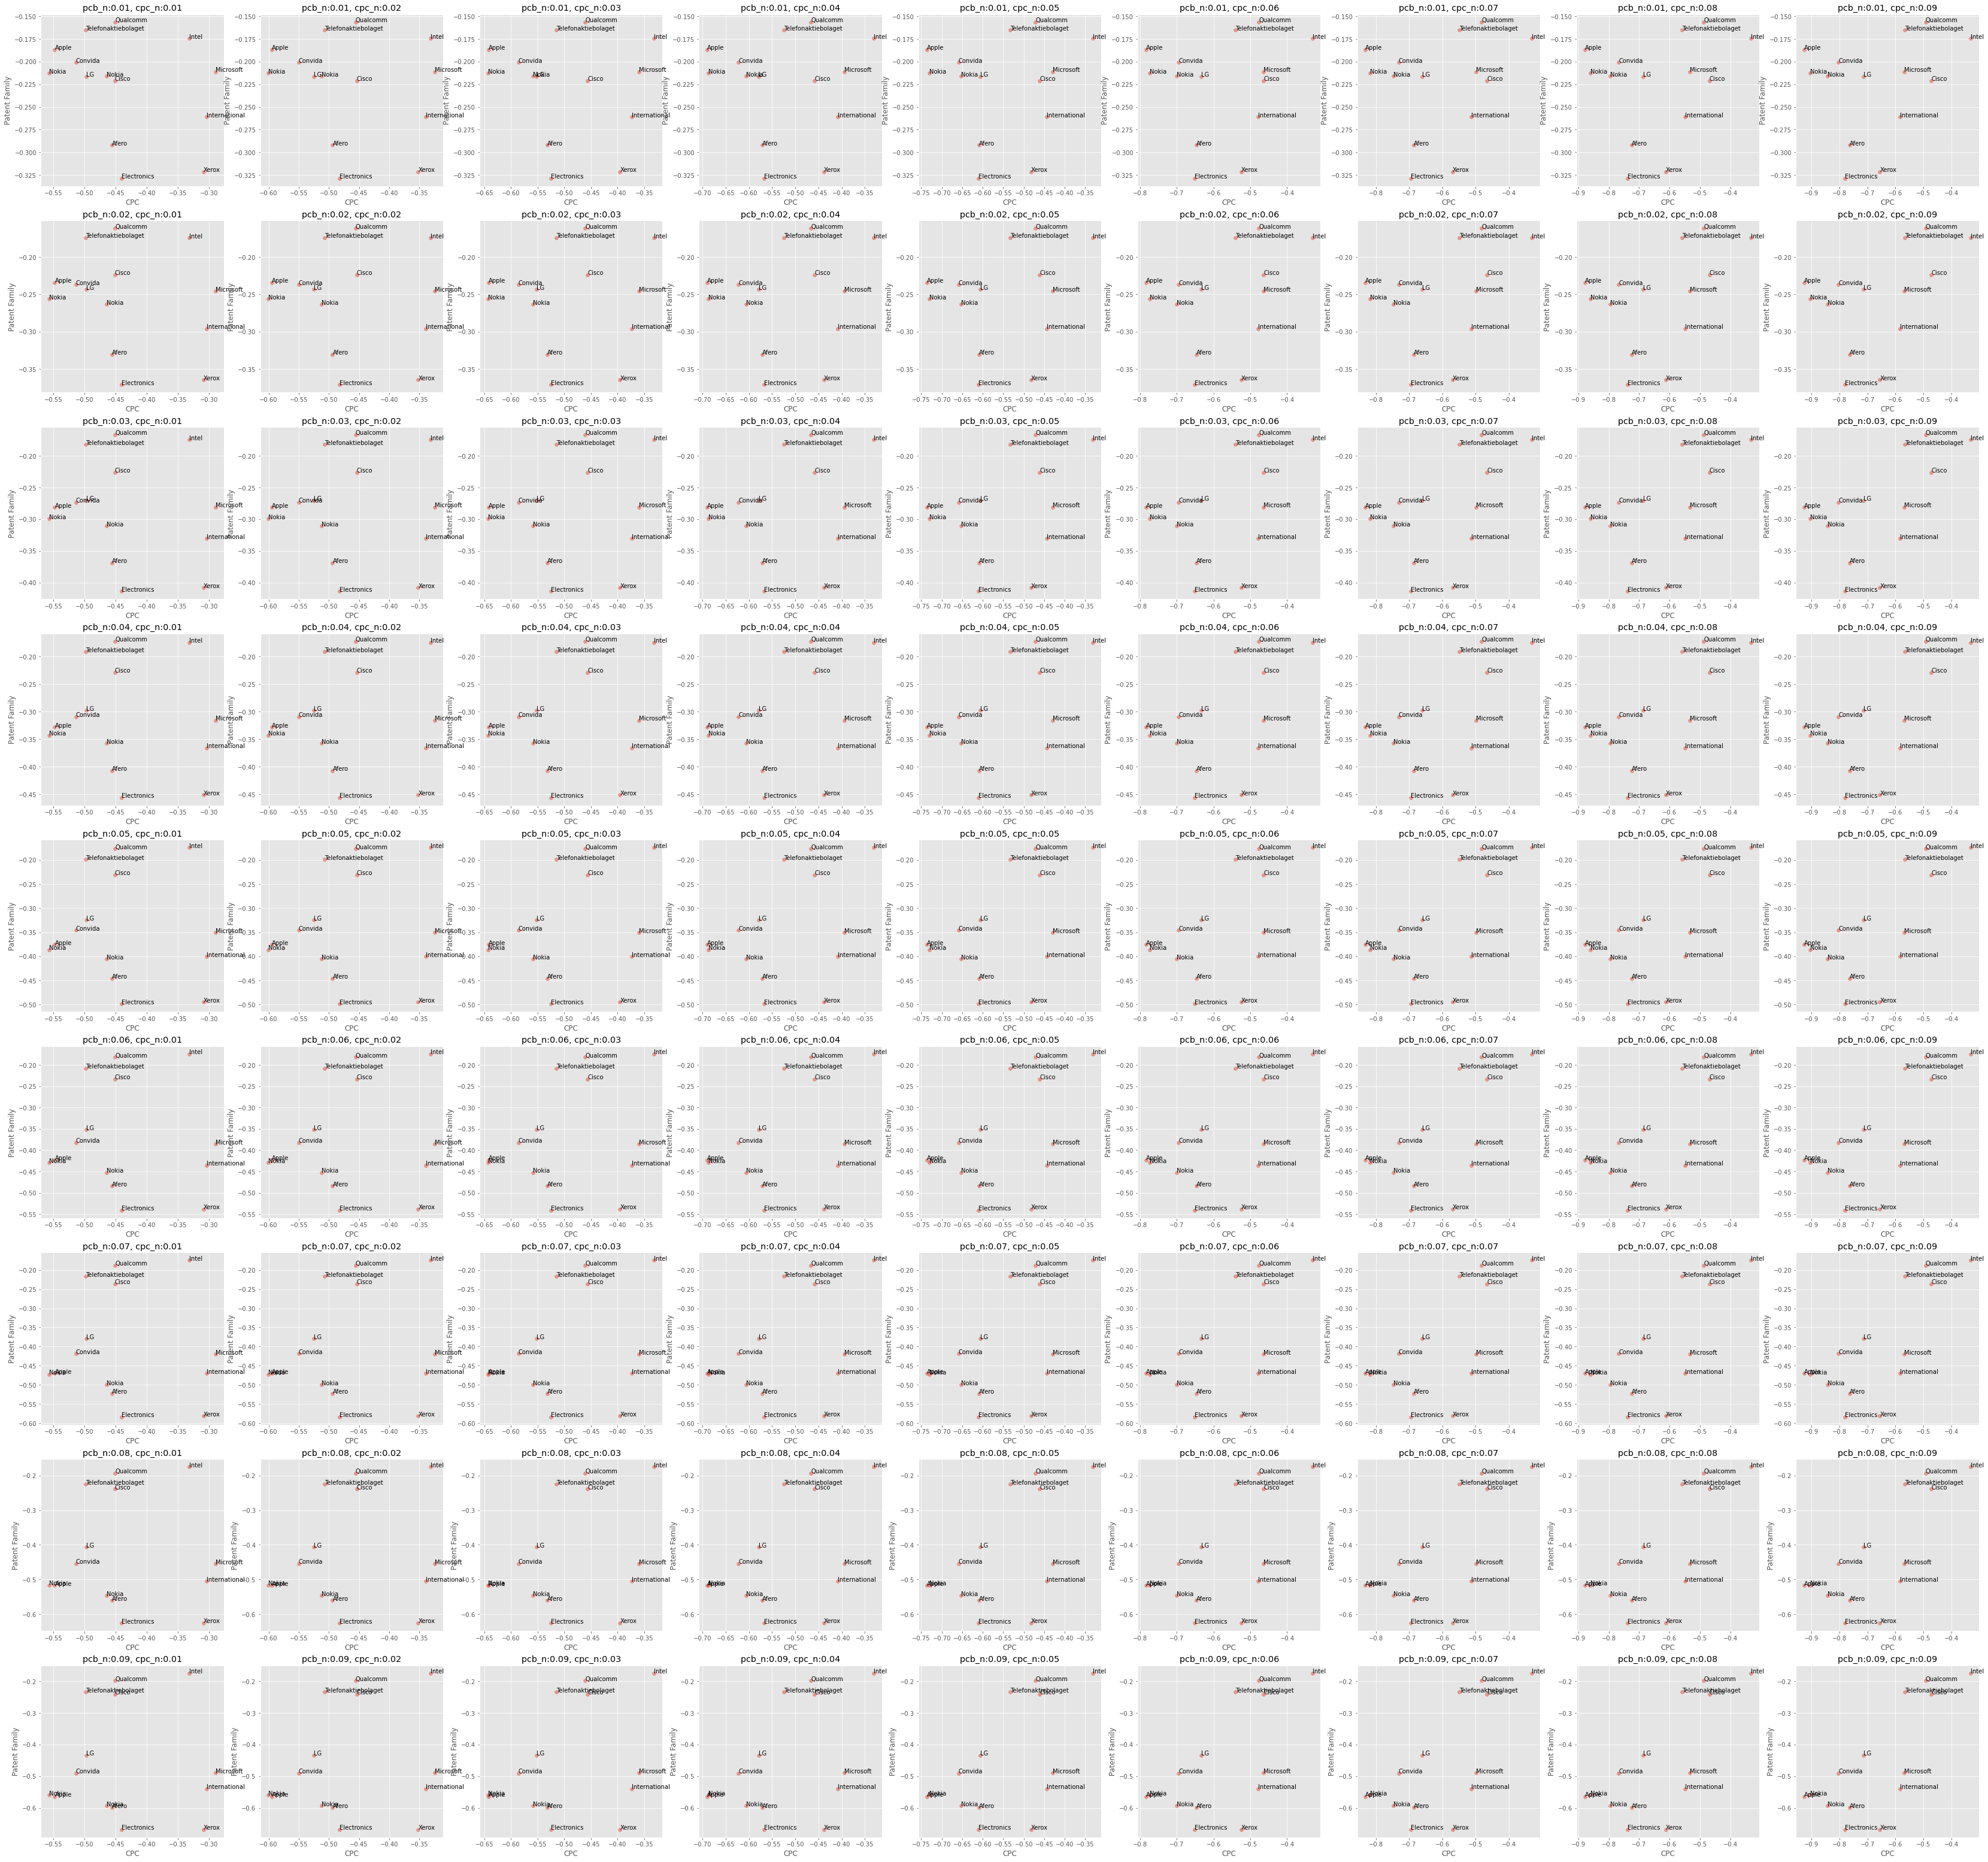

In [42]:
pcb_n_ls=np.arange(0.01,0.1,0.01)
cpc_n_ls=np.arange(0.01,0.1,0.01)

n=0
plt.figure(figsize=(58,56))
plt.style.use('ggplot')

for i,pcb_n in enumerate(pcb_n_ls):
    for k,cpc_n in enumerate(cpc_n_ls):
        # print(pcb_n,cpc_n)
        c_df = scatter_plot(pcb_n,cpc_n)
        c_df = c_df.drop("Samsung Electronics Co Ltd")
        

        #plot
        plt.subplot(len(pcb_n_ls), len(cpc_n_ls), n + 1)
        plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
        plt.title("pcb_n:{}, cpc_n:{}".format(round(pcb_n,2),round(cpc_n,2)))
        plt.xlabel("CPC")
        plt.ylabel("Patent Family")

        for i, txt in enumerate(c_df.index):
            plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])

            
        n+=1
plt.savefig('./img/years/plot_us_5_2.png'.format(pcb_n))

In [43]:
c_df

,cpc,country
company,,
Intel Corp,0.331489,0.174634
Cisco Technology Inc,0.471155,0.241096
Qualcomm Inc,0.492350,0.198192
Telefonaktiebolaget LM Ericsson AB,0.567024,0.234029
LG Electronics Inc,0.714747,0.433656
International Business Machines Corp,0.583139,0.540124
Microsoft Technology Licensing LLC,0.568676,0.490105
Convida Wireless LLC,0.803743,0.490665
Afero Inc,0.762607,0.599247


In [110]:
c_df = pd.DataFrame((zip(list(ccpc_pcb["pcb"]), list(ccontry_pcb["pcb"]))), columns = ['cpc', 'country'])

In [111]:
c_df.set_index(ccpc_pcb.index, inplace=True)
c_df

,cpc,country
company,,
Qualcomm Inc,0.468491,0.177136
Samsung Electronics Co Ltd,0.312979,0.207972
Intel Corp,0.358799,0.221603
Telefonaktiebolaget LM Ericsson AB,0.538092,0.194568
International Business Machines Corp,0.304233,0.314296
LG Electronics Inc,0.387508,0.262568
Cisco Technology Inc,0.552194,0.326665
Microsoft Technology Licensing LLC,0.518391,0.345391
Huawei Technologies Co Ltd,0.734943,0.335925


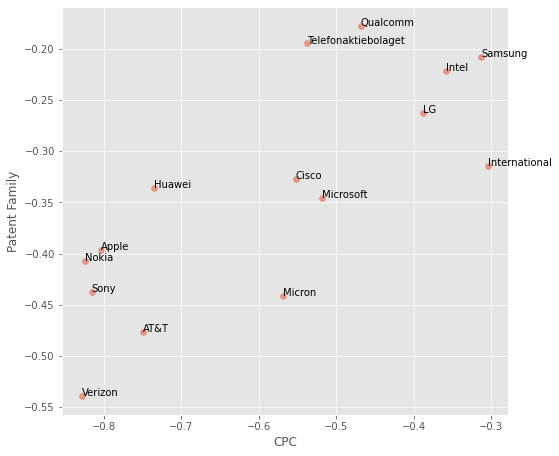

In [112]:
plt.figure(figsize=(8,7.5))
plt.style.use('ggplot')

plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
plt.xlabel("CPC")
plt.ylabel("Patent Family")

for i, txt in enumerate(c_df.index):
    plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])
    
plt.show()

# Scatter Plot 2
- Intel Corp

In [85]:
ccontry_pcb_ibm = ccontry2.loc[com_ls,:].copy()
ccontry_pcb_ibm["sum"] = ccontry_pcb_ibm.apply(lambda x: PCB(ccontry_pcb_ibm.loc["Intel Corp",:],x), axis=1)

In [93]:
pcb_ls=[]
n=0.4

for i in ccontry_pcb_ibm.index:
    pcb = ccontry_pcb_ibm.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Intel Corp"].values-com_df.count_log[com_df.company==i].values)**2)
    pcb_ls.append(pcb[0])
    
ccontry_pcb_ibm["pcb"]=pcb_ls

In [94]:
ccpc_pcb_ibm = ccpc2.loc[com_ls,:].copy()
ccpc_pcb_ibm["sum"] = ccpc_pcb_ibm.apply(lambda x: PCB(ccpc_pcb_ibm.loc["Intel Corp",:],x), axis=1)

In [99]:
pcb_ls=[]
n=0.35

for i in ccpc_pcb_ibm.index:
    pcb = ccpc_pcb_ibm.loc[[i],:]["sum"].values+n*((com_df.count_log[com_df.company=="Intel Corp"].values-com_df.count_log[com_df.company==i].values)**2)
    pcb_ls.append(pcb[0])
    
ccpc_pcb_ibm["pcb"]=pcb_ls

In [100]:
c_df = pd.DataFrame((zip(list(ccpc_pcb_ibm["pcb"]), list(ccontry_pcb_ibm["pcb"]))), columns = ['cpc', 'country'])
c_df.set_index(ccpc_pcb_ibm.index, inplace=True)

In [101]:
# c_df

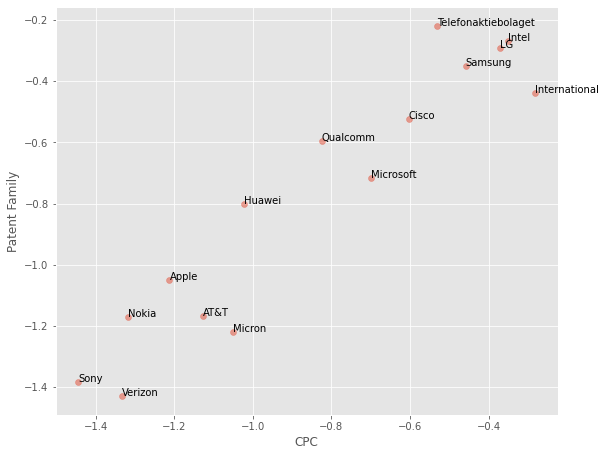

In [102]:
plt.figure(figsize=(9,7.5))
plt.style.use('ggplot')

plt.scatter(-c_df.cpc, -c_df.country, alpha=0.5)
plt.xlabel("CPC")
plt.ylabel("Patent Family")

for i, txt in enumerate(c_df.index):
    plt.text(-c_df.cpc[i], -c_df.country[i],txt.split(" ")[0])
    
plt.show()

# Scatter Plot 3
- 全部

In [67]:
com_df2=com_df.copy()

In [68]:
com_df2.loc[len(com_df2)]=["all",33072,10.40644228192155]

In [69]:
com_df2

,company,count,count_log
0,Qualcomm Inc,8491,9.046762
1,Samsung Electronics Co Ltd,6337,8.754161
2,Intel Corp,3236,8.082093
3,Telefonaktiebolaget LM Ericsson AB,2488,7.819234
4,Huawei Technologies Co Ltd,2461,7.808323
5,LG Electronics Inc,1931,7.565793
6,International Business Machines Corp,1591,7.372118
7,Apple Inc,1104,7.006695
8,Cisco Technology Inc,1092,6.995766
9,Microsoft Technology Licensing LLC,963,6.870053


In [70]:
ccontry_all = ccontry.loc[com_ls,:].copy()
ccontry_all.loc["all"] = list(ccontry_all.apply(lambda x: sum(x),axis=0))
ccontry_all

,AP,AR,AT,AU,BE,BG,BR,CA,CH,CL,...,SI,SM,TN,TR,TW,UA,US,UY,WO,ZA
company,,,,,,,,,,,,,,,,,,,,,
Qualcomm Inc,0.0,14.0,0.0,528.0,0.0,0.0,1328.0,532.0,0.0,57.0,...,12.0,0.0,8.0,0.0,2153.0,0.0,8345.0,0.0,7747.0,17.0
Samsung Electronics Co Ltd,0.0,0.0,0.0,147.0,0.0,0.0,9.0,34.0,0.0,0.0,...,0.0,0.0,0.0,0.0,217.0,0.0,6175.0,0.0,3438.0,0.0
Intel Corp,0.0,0.0,0.0,9.0,0.0,0.0,60.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,167.0,0.0,3254.0,0.0,1546.0,0.0
Telefonaktiebolaget LM Ericsson AB,2.0,182.0,0.0,136.0,0.0,0.0,348.0,140.0,0.0,21.0,...,0.0,0.0,0.0,7.0,61.0,0.0,2331.0,0.0,2436.0,139.0
Huawei Technologies Co Ltd,0.0,2.0,0.0,75.0,0.0,0.0,204.0,81.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1341.0,0.0,2117.0,4.0
LG Electronics Inc,0.0,1.0,0.0,31.0,0.0,0.0,25.0,16.0,0.0,12.0,...,0.0,0.0,0.0,0.0,10.0,0.0,1859.0,0.0,1294.0,1.0
International Business Machines Corp,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1687.0,0.0,142.0,2.0
Apple Inc,0.0,0.0,0.0,8.0,0.0,0.0,18.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,62.0,0.0,1045.0,0.0,1013.0,0.0
Cisco Technology Inc,0.0,0.0,0.0,13.0,0.0,0.0,0.0,54.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1160.0,0.0,326.0,0.0


In [71]:
ccontry_pcb_all = ccontry_all.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1
ccontry_pcb_all["sum"] = ccontry_pcb_all.apply(lambda x: PCB(ccontry_pcb_all.loc["all",:],x), axis=1)

In [72]:
pcb_ls=[]

for i in ccontry_pcb_all.index:
    pcb = ccontry_pcb_all.loc[[i],:]["sum"].values+(com_df2.count_log[com_df2.company=="all"].values-com_df2.count_log[com_df2.company==i].values)**2
    pcb_ls.append(pcb[0])
    
ccontry_pcb_all["pcb"]=pcb_ls

In [73]:
ccontry_pcb_all

,AP,AR,AT,AU,BE,BG,BR,CA,CH,CL,...,TN,TR,TW,UA,US,UY,WO,ZA,sum,pcb
company,,,,,,,,,,,,,,,,,,,,,
Qualcomm Inc,0.000000,0.000397,0.0,0.014962,0.0,0.0,0.037632,0.015076,0.0,0.001615,...,0.000227,0.000000,0.061011,0.0,0.236476,0.0,0.219530,0.000482,0.158672,2.007403
Samsung Electronics Co Ltd,0.000000,0.000000,0.0,0.006181,0.0,0.0,0.000378,0.001430,0.0,0.000000,...,0.000000,0.000000,0.009124,0.0,0.259628,0.0,0.144551,0.000000,0.166404,2.896438
Intel Corp,0.000000,0.000000,0.0,0.001009,0.0,0.0,0.006723,0.000448,0.0,0.000000,...,0.000000,0.000000,0.018714,0.0,0.364635,0.0,0.173241,0.000000,0.177056,5.579654
Telefonaktiebolaget LM Ericsson AB,0.000166,0.015076,0.0,0.011266,0.0,0.0,0.028827,0.011597,0.0,0.001740,...,0.000000,0.000580,0.005053,0.0,0.193091,0.0,0.201789,0.011514,0.146153,6.839798
Huawei Technologies Co Ltd,0.000000,0.000249,0.0,0.009330,0.0,0.0,0.025376,0.010076,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.166812,0.0,0.263341,0.000498,0.174032,6.924255
LG Electronics Inc,0.000000,0.000169,0.0,0.005237,0.0,0.0,0.004224,0.002703,0.0,0.002027,...,0.000000,0.000000,0.001689,0.0,0.314073,0.0,0.218618,0.000169,0.175053,8.244340
International Business Machines Corp,0.000000,0.000000,0.0,0.000433,0.0,0.0,0.000867,0.000433,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.730936,0.0,0.061525,0.000867,0.221396,9.428520
Apple Inc,0.000000,0.000000,0.0,0.001978,0.0,0.0,0.004450,0.000494,0.0,0.000000,...,0.000000,0.000000,0.015328,0.0,0.258344,0.0,0.250433,0.000000,0.177627,11.735907
Cisco Technology Inc,0.000000,0.000000,0.0,0.006523,0.0,0.0,0.000000,0.027095,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.582037,0.0,0.163573,0.000000,0.217016,11.849727


In [74]:
ccpc

,A01,A21,A22,A23,A24,A41,A42,A43,A44,A45,...,G16,G21,H01,H02,H03,H04,H05,Y02,Y04,Y10
company,,,,,,,,,,,,,,,,,,,,,
#glowontech,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
(c-Dot),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0
01 Bulletin Laboratory Co,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0
01 COMMUNIQUE LABORATORY Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0
0Chain LLC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
incNETWORKS Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,31.0,0.0,0.0,0.0,0.0
mSignia Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0
nChain Holdings Ltd,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,138.0,0.0,0.0,0.0,0.0


In [75]:
# ccpc.set_index("company", inplace=True)
ccpc_all = ccpc.loc[com_ls,:].copy()
ccpc_all.loc["all"] = list(ccpc_all.apply(lambda x: sum(x),axis=0))

In [76]:
ccpc_all2 = ccpc_all.apply(lambda x: x/sum(x), axis=1) #比例 row(axis=1)加總為1

# ccpc_pcb_ibm = ccpc2.loc[com_ls,:].copy()
ccpc_all2["sum"] = ccpc_all2.apply(lambda x: PCB(ccpc_all2.loc["all",:],x), axis=1)

In [77]:
ccpc_all2

,A01,A21,A22,A23,A24,A41,A42,A43,A44,A45,...,G21,H01,H02,H03,H04,H05,Y02,Y04,Y10,sum
company,,,,,,,,,,,,,,,,,,,,,
Qualcomm Inc,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000011,0.000000,...,0.0,0.027181,0.000976,0.017746,0.895970,0.001837,0.008356,0.000287,0.000000,0.609196
Samsung Electronics Co Ltd,0.000000,0.0,0.0,0.000027,0.000000,0.000135,0.000014,0.000122,0.000243,0.000635,...,0.0,0.061415,0.013321,0.015469,0.511531,0.012415,0.009308,0.000405,0.000230,0.384074
Intel Corp,0.000427,0.0,0.0,0.000000,0.000000,0.000152,0.000000,0.000091,0.000000,0.000000,...,0.0,0.108724,0.011915,0.013408,0.471676,0.007283,0.014596,0.001006,0.000061,0.368426
Telefonaktiebolaget LM Ericsson AB,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.003385,0.000564,0.011566,0.919544,0.001016,0.012130,0.000621,0.000000,0.624779
Huawei Technologies Co Ltd,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.007350,0.000817,0.013476,0.901762,0.000992,0.014409,0.000233,0.000000,0.615068
LG Electronics Inc,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000132,0.000044,0.000000,0.000175,...,0.0,0.002325,0.001491,0.003334,0.618222,0.003115,0.008291,0.000307,0.000000,0.438017
International Business Machines Corp,0.001758,0.0,0.0,0.000000,0.000070,0.000070,0.000000,0.000000,0.000000,0.000000,...,0.0,0.078492,0.007455,0.002391,0.264594,0.001829,0.009917,0.002040,0.000141,0.252434
Apple Inc,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.002985,0.001357,0.004884,0.930361,0.000000,0.012119,0.000090,0.000000,0.631630
Cisco Technology Inc,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.004466,0.006597,0.001522,0.746575,0.003451,0.013701,0.004770,0.000101,0.532885


In [78]:
pcb_ls=[]

for i in ccpc_all2.index:
    pcb = ccpc_all2.loc[[i],:]["sum"].values+(com_df2.count_log[com_df2.company=="all"].values-com_df2.count_log[com_df2.company==i].values)**2
    pcb_ls.append(pcb[0])
#     print(ccpc_all.loc[[i],:]["sum"].values)
    
ccpc_all2["pcb"]=pcb_ls

In [79]:
c_df = pd.DataFrame((zip(list(ccpc_all2["pcb"]), list(ccontry_pcb_all["pcb"]))), columns = ['cpc', 'country'])
c_df.set_index(ccpc_all2.index, inplace=True)

In [80]:
c_df

,cpc,country
company,,
Qualcomm Inc,2.457926,2.007403
Samsung Electronics Co Ltd,3.114108,2.896438
Intel Corp,5.771025,5.579654
Telefonaktiebolaget LM Ericsson AB,7.318423,6.839798
Huawei Technologies Co Ltd,7.365291,6.924255
LG Electronics Inc,8.507303,8.244340
International Business Machines Corp,9.459558,9.428520
Apple Inc,12.189910,11.735907
Cisco Technology Inc,12.165597,11.849727


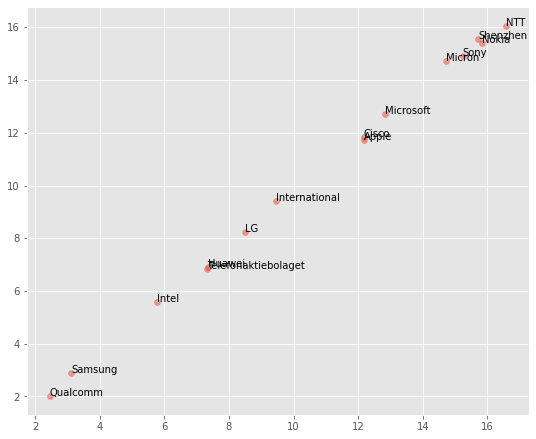

In [81]:
c_df2 = c_df.drop(["all"])

plt.figure(figsize=(9,7.5))
plt.style.use('ggplot')

plt.scatter(c_df2.cpc, c_df2.country, alpha=0.5)

for i, txt in enumerate(c_df2.index):
    plt.text(c_df2.cpc[i], c_df2.country[i],txt.split(" ")[0])
    
plt.show()